<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


### CCUS Global GOM Spatial GeoAnalytics Workflow

## GOM Saline Aquifer Data - Confidential Data - Do Note Share Nor Publish Data and Results

#### Michael Pyrcz, Associate Professor

### The University of Texas at Austin

#### Michael's Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

#### Murray Christie and Richard Longhurst

### IHSMarkit


#### Comments on the First Draft

1. Demonstration of 3D trend modeling for diagnostics and rapid data imputation and pre-injection prediction.

#### Import Required Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats                     # summary statistics
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
from matplotlib import path
from matplotlib.colors import ListedColormap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle        # drawing shapes on plots
plt.rc('axes', axisbelow=True)            # set axes and grids in the background for all plots
import seaborn as sns                     # for matrix scatter plots
import os
import re
cmap = plt.cm.inferno
from scipy import linalg                  # for linear regression
from sklearn.manifold import MDS          # multidimensional scaling
import math
import astropy.convolution.convolve as convolve
import scipy.signal as signal             # kernel for moving window calculation

import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
                 
from scipy.interpolate import make_interp_spline, BSpline
    
from ipywidgets import interactive                        # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
# make a custom colormap
my_colormap = plt.cm.get_cmap('RdBu_r', 256)
newcolors = my_colormap(np.linspace(0, 1, 256))
white = np.array([250/256, 250/256, 250/256, 1])
#newcolors[26:230, :] = white                        # mask all correlations less than abs(0.8)
newcolors[56:200, :] = white                          # mask all correlations less than abs(0.6)
signif = ListedColormap(newcolors)

#### Declare Functions

These include:

* convenience functions for extracting, calculating and ploting the polygons (single polygons and multipolygons) stored as strings in the DataFrame

* partial correlation and mutual information functions for enhanced correlation analysis

In [3]:
def add_grid():
    plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

def partial_corr(C): # function by Fabian Pedregosa-Izquierdo, f@bianp.net for partial correlation
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual
    
def cond_prob_plot(pred,pmin,pmax,pname,punits,nbins,resp,rmin,rmax,rname,runits):
    nbins = nbins + 1
    bins = np.linspace(pmin,pmax,nbins)            # set the bin boundaries and then the centroids for plotting
    centroids = np.linspace((bins[0]+bins[1])*0.5,(bins[nbins-2]+bins[nbins-1])*0.5,nbins-1)
    pnew = np.linspace(pmin,pmax,1000) 
    
    def percentile(n):
        def percentile_(x):
            return np.percentile(x, n)
        percentile_.__name__ = 'percentile_%s' % n
        return percentile_
    
    df_temp = pd.DataFrame({pname:pred,rname:resp})
    df_temp['bins'] = pd.cut(df_temp[pname], bins,labels = centroids) # cut on bondaries and lable with centroids 
    
    #cond_exp = df_temp.groupby('bins')[rname].mean()
    cond_P50 = df_temp.groupby('bins')[rname].agg([percentile(50)])
    cond_P40 = df_temp.groupby('bins')[rname].agg([percentile(40)])
    cond_P60 = df_temp.groupby('bins')[rname].agg([percentile(60)])
    cond_P90 = df_temp.groupby('bins')[rname].agg([percentile(90)])
    cond_P10 = df_temp.groupby('bins')[rname].agg([percentile(10)])
    cond_P25 = df_temp.groupby('bins')[rname].agg([percentile(25)])
    cond_P75 = df_temp.groupby('bins')[rname].agg([percentile(75)])
    cond_n = df_temp.groupby('bins')[pname].count()
    
    plt.scatter(pred,resp,c='black',edgecolor='black',s=20,alpha=0.01)
    
    spl_cond_P50 = make_interp_spline(centroids,cond_P50, k=2); cond_P50_smooth = spl_cond_P50(pnew)
    spl_cond_P25 = make_interp_spline(centroids,cond_P25, k=2); cond_P25_smooth = spl_cond_P25(pnew)
    spl_cond_P75 = make_interp_spline(centroids,cond_P75, k=2); cond_P75_smooth = spl_cond_P75(pnew)
    spl_cond_P10 = make_interp_spline(centroids,cond_P10, k=2); cond_P10_smooth = spl_cond_P10(pnew)
    spl_cond_P90 = make_interp_spline(centroids,cond_P90, k=2); cond_P90_smooth = spl_cond_P90(pnew)
    spl_cond_P60 = make_interp_spline(centroids,cond_P60, k=2); cond_P60_smooth = spl_cond_P60(pnew)
    spl_cond_P40 = make_interp_spline(centroids,cond_P40, k=2); cond_P40_smooth = spl_cond_P40(pnew)
    
    plt.plot(pnew,cond_P50_smooth,color='black',linewidth=2.0)
    plt.plot(pnew,cond_P75_smooth,'r--',color='black',linewidth = 1.0)
    plt.plot(pnew,cond_P25_smooth,'r--',color='black',linewidth = 1.0)
    plt.plot(pnew,cond_P90_smooth,'r--',color='black',linewidth = 0.7)
    plt.plot(pnew,cond_P10_smooth,'r--',color='black',linewidth = 0.7)
    plt.plot(pnew,cond_P60_smooth,'r--',color='black',linewidth = 1.5)
    plt.plot(pnew,cond_P40_smooth,'r--',color='black',linewidth = 1.5)
    plt.gca().fill_between(pnew, cond_P40_smooth.reshape(-1), cond_P60_smooth.reshape(-1),facecolor='red',alpha=0.2,zorder=3)
    plt.gca().fill_between(pnew, cond_P25_smooth.reshape(-1), cond_P75_smooth.reshape(-1),facecolor='yellow',alpha=0.2,zorder=2)
    plt.gca().fill_between(pnew, cond_P10_smooth.reshape(-1), cond_P90_smooth.reshape(-1),facecolor='grey',alpha=0.2,zorder=1)
    
    plt.xlim([pmin,pmax]); plt.ylim([rmin,rmax])
    plt.xlabel(pname + ' (' + punits + ')')
    plt.ylabel(rname + ' (' + runits + ')' + ' | ' + pname + ' (' + punits + ')')
    t = plt.title(rname + ' Conditional on ' + pname)
    plt.xlim(min(bins),max(bins))
    add_grid()
    
    for xbin in bins:
        plt.vlines(xbin,rmin,rmax,color='black',linestyle=(0, (1, 10)),linewidth=1)
        
    for xcentroid in centroids:
        plt.vlines(xcentroid,rmin,rmax,color='black',linestyle=(0, (5, 5)),linewidth=1)
        
    return spl_cond_P50,spl_cond_P10,spl_cond_P90
        
def weighted_avg_and_std(values, weights):                  # from Eric O Lebigot, stack overflow
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc): # from iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049 
    """
    perc : percentile in [0-1]!
    """
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):                     
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')
   

#### Set Working Directory

In [9]:
#os.chdir(r"C:\Users\17137\OneDrive - The University of Texas at Austin\IHS\CCUS")

os.chdir(r"C:\Users\pm27995\OneDrive - The University of Texas at Austin\IHS\CCUS2\Data")

#os.chdir(r"C:\LocalWork\IHSMarkit\CCUS")

#### Read the Data Files

In [10]:
df_header = pd.read_csv(r'Export - Excel Well Workbook2_Header.csv')

In [5]:
#text = pd.read_csv("Kingdom Eagle Ford Log Data.csv", skiprows=1000, chunksize=1000)

#df = pd.read_csv("Kingdom Eagle Ford Log Data.csv", nrows=10)
#df = pd.concat(text, ignore_index=True)
#df = text.get_chunk(1000)
#df = pd.DataFrame(text.get_chunk(10))

#df = pd.read_csv("test3_wilcox.csv")
#df = pd.read_csv("test2.txt")

# df_poly = df_poly[['FIELD_NAME','WKT']]
# df_poly = df_poly.rename(columns = {'FIELD_NAME':'field_name','WKT':'wkt'})
# df_poly.dropna(axis=0,how='any',inplace=True)
# df_poly = df_poly.drop_duplicates(subset='field_name',keep = 'first') # assuming duplicates have the same polygons - spot checked 'Cote Blanche Bay West'
# df_poly.set_index('field_name')
# df_poly.head()
# #df_poly.describe()
# #len(df_poly)

# df.head()
# df.describe().transpose()
# df.describe()

In [7]:
# Dataframes implement the Pandas API
filename = "Kingdom Eagle Ford Log Data.csv"
import dask.dataframe as dd
df = dd.read_csv(filename,usecols = ['UWI','SurfaceLocationX','SurfaceLocationY','TVD','Depth','RHOB','DT','NPHI','VP_calc','SandPerc','Formation Top'],dtype={'Formation Top': 'object'})
df.head()
len(df)

23561683

In [8]:
selected_formation = 'WILCOX'
df_wilcox = df[df['Formation Top']==selected_formation]
df_wilcox.head()
nsample = len(df_wilcox)
type(df_wilcox)
len(df_wilcox)

2491751

In [8]:
df_pandas_wilcox = df_wilcox.compute()
len(df_pandas_wilcox)

2491751

In [9]:
df_pandas_wilcox.head(n=100)

,UWI,TVD,RHOB,DT,NPHI,VP_calc,SandPerc,Formation Top,SurfaceLocationX,SurfaceLocationY,Depth
62692,42311316470000,3507.0,NaN,NaN,0.416400,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3507.00
62693,42311316470000,3507.0,NaN,NaN,0.396275,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3507.25
62694,42311316470000,3507.0,NaN,NaN,0.379400,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3507.50
62695,42311316470000,3507.0,NaN,NaN,0.368713,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3507.75
62696,42311316470000,3507.0,NaN,NaN,0.359400,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3508.00
...,...,...,...,...,...,...,...,...,...,...,...
62787,42311316470000,3507.0,NaN,NaN,0.311906,NaN,0.240507,WILCOX,2.076912e+06,198029.826543,3530.75
62788,42311316470000,3507.0,NaN,NaN,0.317000,NaN,0.234680,WILCOX,2.076912e+06,198029.826543,3531.00
62789,42311316470000,3507.0,NaN,NaN,0.321306,NaN,0.224505,WILCOX,2.076912e+06,198029.826543,3531.25
62790,42311316470000,3507.0,NaN,NaN,0.326000,NaN,0.219453,WILCOX,2.076912e+06,198029.826543,3531.50


In [10]:
df_pandas_wilcox.describe()

,UWI,TVD,RHOB,DT,NPHI,VP_calc,SandPerc,SurfaceLocationX,SurfaceLocationY,Depth
count,2.491751e+06,2.491751e+06,93452.000000,769794.000000,562110.000000,769605.000000,1.523350e+05,2.489172e+06,2.489172e+06,2.489172e+06
mean,4.226885e+13,5.517915e+03,2.315558,92.815527,18.822385,10942.877619,1.488063e+00,2.139471e+06,1.581959e+05,7.401778e+03
std,8.259101e+10,2.205437e+03,0.195044,11.395806,64.352716,1421.481046,2.868106e+01,6.052948e+04,8.035422e+04,3.153794e+03
min,4.201303e+13,1.744000e+03,1.344813,-5.912569,-1.322481,5006.559191,2.543132e-07,1.996283e+06,2.810762e+04,1.754000e+03
25%,4.228300e+13,3.422000e+03,2.218400,86.237368,0.277300,10095.829971,9.537744e-02,2.109685e+06,8.271782e+04,4.865500e+03
50%,4.231102e+13,4.530000e+03,2.382412,92.323097,0.351100,10831.818400,2.413775e-01,2.152993e+06,1.831147e+05,6.422000e+03
75%,4.231132e+13,8.160000e+03,2.455331,99.057051,24.360001,11596.132346,5.598723e-01,2.195863e+06,2.217620e+05,9.580250e+03
max,4.247939e+13,9.784000e+03,2.703156,250.991913,598.637329,27005.348861,1.005487e+04,2.224584e+06,3.063046e+05,1.717400e+04


#### Check the Data Coverage

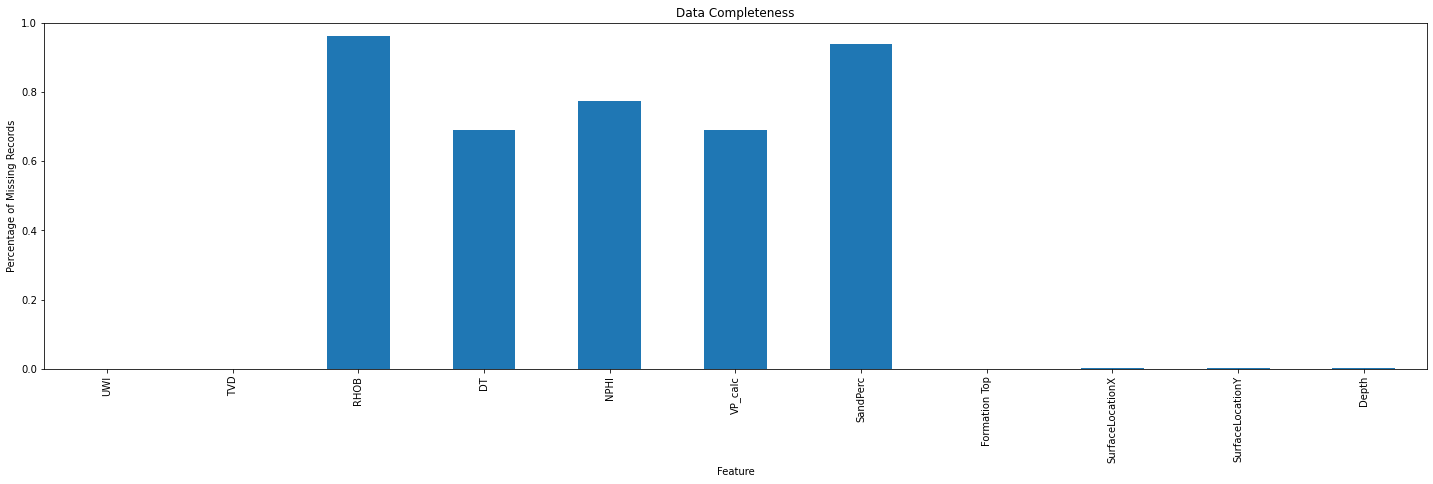

In [11]:
(df_pandas_wilcox.isnull().sum()/len(df_pandas_wilcox)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])
plt.show()

#### Specify the Features of Interest

In [12]:
TVDmin = 3000; TVDmax = 18000
RHOBmin = 1.5; RHOBmax = 3.0
DTmin = 50.0; DTmax = 150.0
NPHImin = 0.0; NPHImax = 0.80
VPmin = 5000; VPmax = 20000
Sandmin = 0.0; Sandmax = 1.0

pfeatures = ['RHOB','DT','NPHI','VP_calc']
pmin = [RHOBmin,DTmin,NPHImin,VPmin]
pmax = [RHOBmax,DTmax,NPHImax,VPmax]
pname = ['Density','Sonic','Porosity','Velocity Primary']
punits = ['$g/cm^3$','$\mu m/s$','fraction','$m/s$']

#### Grid Specification

In [13]:
xmin = 1990000; xmax = 2250000
ymin = 40000; ymax = 300000
nx = 100; ny = 100

xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
xmn = xmin + xsiz*0.5; ymn = ymin + ysiz*0.5

xx, yy = np.meshgrid(np.arange(xmn, xmax, xsiz), np.arange(ymax-ysiz*0.5, ymin, -1 * ysiz))

print('nx: ' + str(nx) + ' , xmn: ' + str(xmn) + ' , xsiz: ' + str(xsiz))
print('ny: ' + str(ny) + ' , ymn: ' + str(ymn) + ' , ysiz: ' + str(ysiz))

print('extents x: ' + str(xmin) + ' - ' + str(xmax) + ' = ' + str(xmax-xmin) + ', extents y: ' + str(ymin) + ' - ' + str(ymax) + ' = ' + str(ymax-ymin))

nx: 100 , xmn: 1991300.0 , xsiz: 2600.0
ny: 100 , ymn: 41300.0 , ysiz: 2600.0
extents x: 1990000 - 2250000 = 260000, extents y: 40000 - 300000 = 260000


#### Data Cleaning

In [14]:
selected_formation = 'WILCOX'; exhaustive_features = ['NPHI']
df_clean = df_pandas_wilcox.copy(deep=True)
df_clean = df_clean.rename(columns = {'SurfaceLocationX':'X','SurfaceLocationY':'Y'})
df_clean.dropna(axis=0,how='any',subset = exhaustive_features ,inplace=True)
df_clean = df_clean.reset_index(drop = True)

df_clean['Depth Prime'] = np.where(df_clean['TVD']!= 'NaN', df_clean['Depth'], df_clean['TVD'])
df_clean['NPHI'] = np.where(df_clean['NPHI']>1.0, df_clean['NPHI']/100, df_clean['NPHI'])
df_clean.head()

df_clean_nonan = df_clean.copy(deep = True)
df_clean_nonan.dropna(axis=0,how='any',subset = pfeatures ,inplace=True)
df_clean_nonan = df_clean_nonan.reset_index(drop = True)

print('Number of samples with porosity = ' + str(len(df_clean)) + ' , number of samples without NaNs = ' + str(len(df_clean_nonan)))

Number of samples with porosity = 562110 , number of samples without NaNs = 22658


In [15]:
np.where((df_clean['NPHI']>1.0, df_clean['NPHI']/100, df_clean['NPHI']))[1].shape

(1136046,)

In [16]:
df_clean.head(n=20)

,UWI,TVD,RHOB,DT,NPHI,VP_calc,SandPerc,Formation Top,X,Y,Depth,Depth Prime
0,42311316470000,3507.0,NaN,NaN,0.416400,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3507.00,3507.00
1,42311316470000,3507.0,NaN,NaN,0.396275,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3507.25,3507.25
2,42311316470000,3507.0,NaN,NaN,0.379400,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3507.50,3507.50
3,42311316470000,3507.0,NaN,NaN,0.368713,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3507.75,3507.75
4,42311316470000,3507.0,NaN,NaN,0.359400,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3508.00,3508.00
5,42311316470000,3507.0,NaN,NaN,0.345756,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3508.25,3508.25
6,42311316470000,3507.0,NaN,NaN,0.333400,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3508.50,3508.50
7,42311316470000,3507.0,NaN,NaN,0.326775,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3508.75,3508.75
8,42311316470000,3507.0,NaN,NaN,0.323700,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3509.00,3509.00
9,42311316470000,3507.0,NaN,NaN,0.321912,NaN,NaN,WILCOX,2.076912e+06,198029.826543,3509.25,3509.25


#### Check for the Number of Wells 

In [17]:
df_clean.nunique()

UWI                  54
TVD                  54
RHOB              32936
DT               102056
NPHI             221666
VP_calc          101888
SandPerc          44276
Formation Top         1
X                    54
Y                    54
Depth             55165
Depth Prime       55165
dtype: int64

#### Check Cleaned Data Summary Statistics

In [18]:
df_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
UWI,562110.0,4.224327e+13,9.592712e+10,4.201332e+13,4.213138e+13,4.228332e+13,4.231132e+13,4.247934e+13
TVD,562110.0,6.521541e+03,2.217708e+03,3.119000e+03,3.878000e+03,7.596000e+03,8.396000e+03,9.187000e+03
RHOB,64540.0,2.279866e+00,2.154385e-01,1.344813e+00,2.126200e+00,2.348900e+00,2.449125e+00,2.703156e+00
DT,124504.0,9.272635e+01,1.374677e+01,4.451600e+01,8.328289e+01,9.154919e+01,1.013868e+02,2.509919e+02
NPHI,562110.0,3.774602e-01,6.071665e-01,-1.322481e+00,2.424000e-01,2.895750e-01,3.359610e-01,5.986373e+00
VP_calc,124333.0,1.100444e+04,1.473247e+03,5.006559e+03,9.867645e+03,1.092705e+04,1.200935e+04,2.246383e+04
SandPerc,55895.0,2.880734e+00,4.629925e+01,1.152900e-05,1.098888e-01,2.861920e-01,7.408290e-01,1.005487e+04
X,562110.0,2.142153e+06,6.670702e+04,2.004573e+06,2.116817e+06,2.161361e+06,2.196137e+06,2.224584e+06
Y,562110.0,1.181210e+05,7.279275e+04,2.810762e+04,6.021637e+04,8.562381e+04,1.887375e+05,2.999215e+05
Depth,562110.0,8.869742e+03,3.357425e+03,3.179000e+03,5.696250e+03,9.080250e+03,1.135525e+04,1.697000e+04


#### Check Feature Coverage

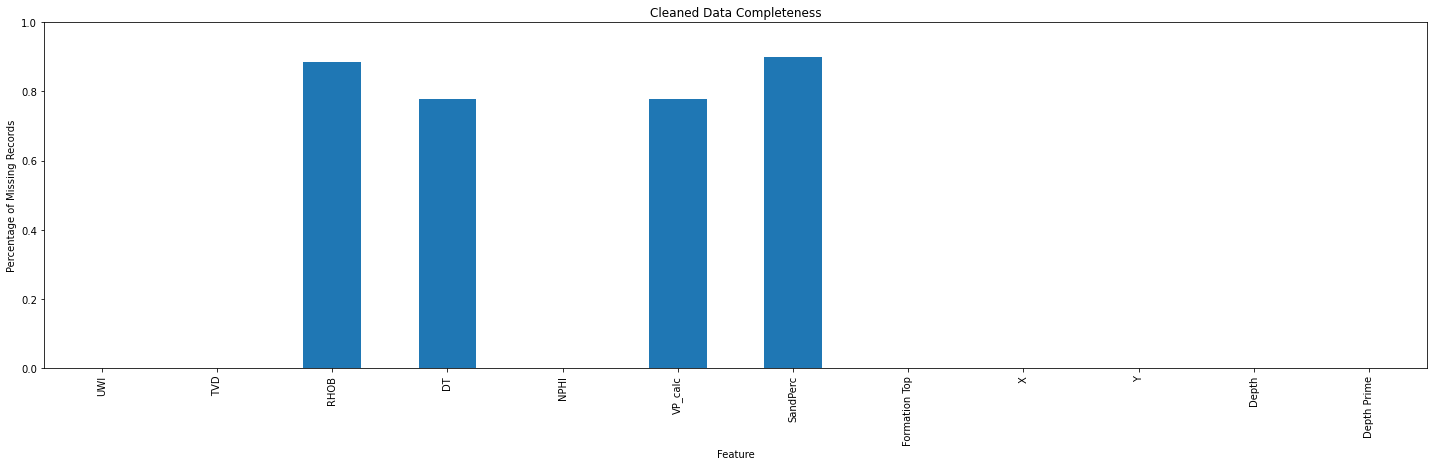

In [130]:
(df_clean.isnull().sum()/len(df_clean)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Cleaned Data Completeness')
plt.ylim([0,1.0])
plt.show()

#### Univariate Statistics

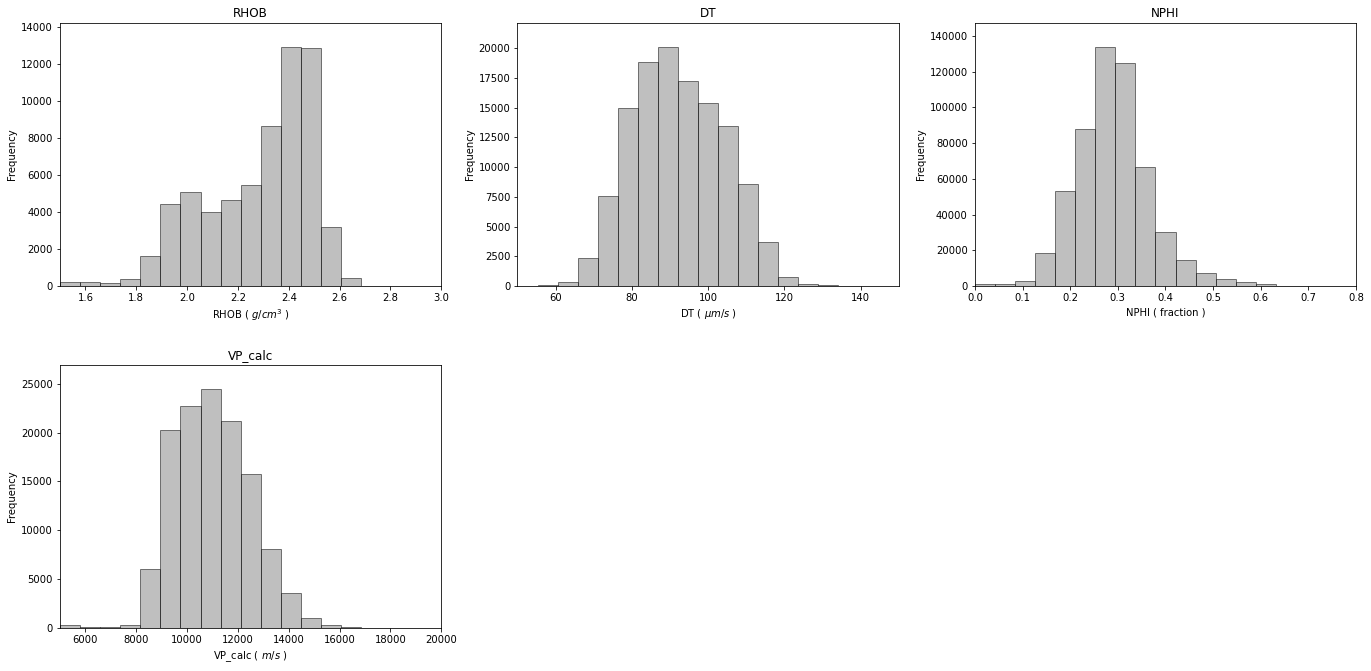

In [20]:
nbins = 20

for i, feature in enumerate(pfeatures):
    plt.subplot(2,3,i+1)
    hist = plt.hist(x=df_clean[feature],weights=None,bins=np.linspace(pmin[i],pmax[i],nbins),alpha = 0.5,edgecolor='black',color='grey')
    plt.xlabel(pfeatures[i] + ' ( '+ punits[i] + ' )'); 
    plt.ylabel('Frequency'); 
    plt.title(pfeatures[i]) # axes labels
    plt.xlim(pmin[i],pmax[i]); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=2.1, wspace=0.2, hspace=0.3)
plt.show()

#### Assign Depth Bins 

For multivariate analysis.

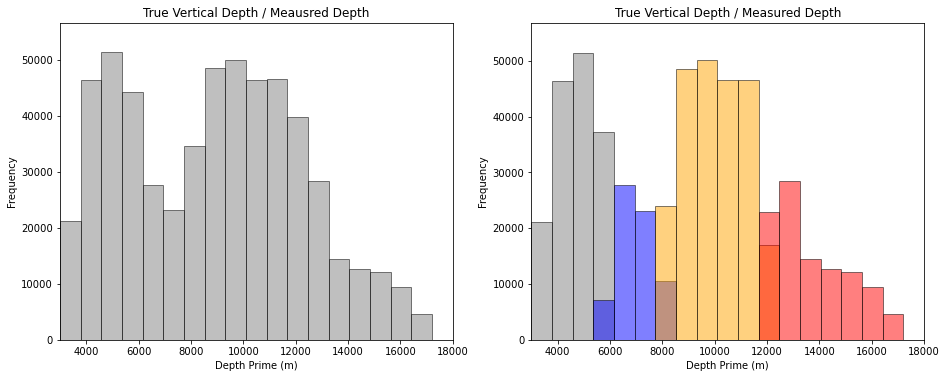

In [21]:
cTVD = ['Shallow','Mid','Deep','Very Deep']
cmapTVD = ['grey','blue','orange','red']
bins = [0, 6000, 8000, 12000,30000]

plt.subplot(121)
hist = plt.hist(x=df_clean['Depth Prime'],weights=None,bins=np.linspace(TVDmin,TVDmax,nbins),alpha = 0.5,edgecolor='black',color='grey')
plt.xlabel('Depth Prime (m)'); 
plt.ylabel('Frequency'); 
plt.title('True Vertical Depth / Meausred Depth') # axes labels
plt.xlim(TVDmin,TVDmax); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents 

df_clean['cTVD'] = pd.cut(x=df_clean['Depth Prime'], bins=bins,labels=cTVD)
df_clean_nonan['cTVD'] = pd.cut(x=df_clean_nonan['Depth Prime'], bins=bins,labels=cTVD)

plt.subplot(122)

for i, TVDbin in enumerate(cTVD):
    hist = plt.hist(x=df_clean[df_clean['cTVD']==TVDbin]['Depth Prime'],color =cmapTVD[i], weights=None,bins=np.linspace(TVDmin,TVDmax,nbins),alpha = 0.5,edgecolor='black')
plt.xlabel('Depth Prime (m)'); 
plt.ylabel('Frequency'); 
plt.title('True Vertical Depth / Measured Depth') # axes labels
plt.xlim(TVDmin,TVDmax); plt.ylim([0,int(max(hist[0]))*2.0])                      # constrain the axes' extents 

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1.1, wspace=0.2, hspace=0.3)
plt.show()

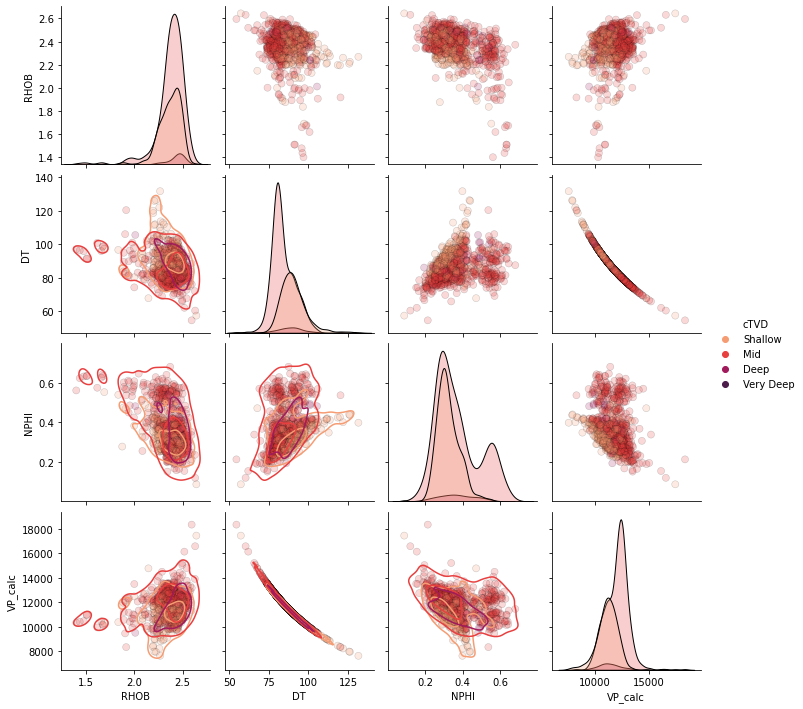

In [22]:
nsample = 1000
dpalette = sns.color_palette("rocket_r",n_colors = len(cTVD))
palette = sns.color_palette("rocket")
matrixplot = sns.pairplot(df_clean_nonan.sample(n=nsample),vars=pfeatures,hue='cTVD',diag_kind = 'kde',palette = dpalette,diag_kws={'edgecolor':'black'},plot_kws=dict(s=50, edgecolor="black", linewidth=0.5,alpha=0.2))
matrixplot.map_lower(sns.kdeplot, levels=3, color="black")
#plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.2, hspace=0.3)
plt.show()

#### Correlation Analysis and Mutual Information

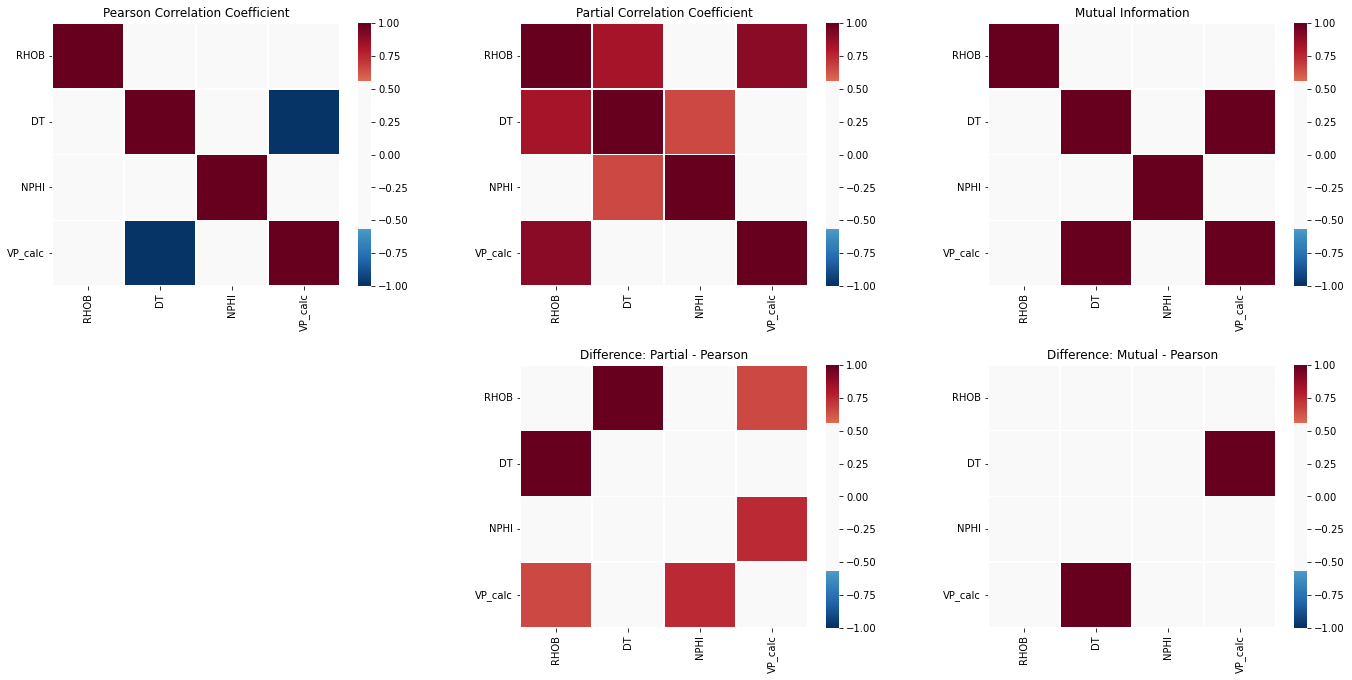

In [23]:
nsample = -1
if nsample > 0:
    df_sample = df_clean_nonan.sample(n=nsample)
else: 
    df_sample = df_clean_nonan
    
plt.subplot(231)                          # plot a color coded correlation matrix
df_corr = df_sample[pfeatures].corr()
sns.heatmap(df_corr,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.title('Pearson Correlation Coefficient')

plt.subplot(232)                          # plot a color coded correlation matrix
partial_correlation = partial_corr(df_sample[pfeatures]) # calculate the partial correlation coefficients
df_partial = pd.DataFrame(partial_correlation,columns=pfeatures,index=pfeatures)
sns.heatmap(df_partial,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.title('Partial Correlation Coefficient')

plt.subplot(233)
df_mutual = pd.DataFrame(mutual_matrix(df_sample[pfeatures],pfeatures),columns=pfeatures,index=pfeatures)
sns.heatmap(df_mutual,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)  
plt.title('Mutual Information')

plt.subplot(235)
sns.heatmap(df_partial-df_corr,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)  
plt.title('Difference: Partial - Pearson')

plt.subplot(236)
plot = sns.heatmap(df_mutual-df_corr,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif) 

plt.title('Difference: Mutual - Pearson')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.3, hspace=0.3)
plt.show()

#df_centroids_age.head(n=200)

#### Predictor Features Conditional to Depth

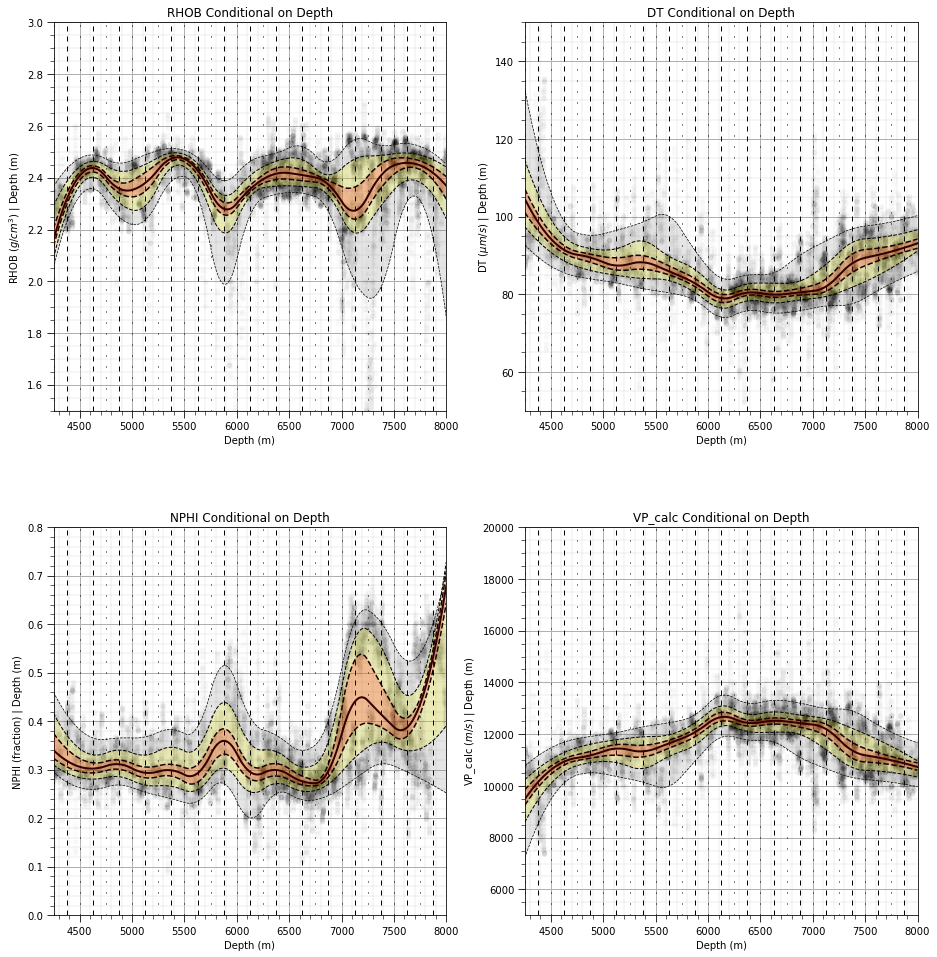

In [24]:
P50splines = []; P10splines = []; P90splines = []

for i, feature in enumerate(pfeatures):

    plt.subplot(2,2,i+1)
    P50spline, P10spline, P90spline = cond_prob_plot(df_clean_nonan['Depth Prime'],4250,8000,'Depth','m',15,df_clean_nonan[pfeatures[i]],pmin[i],pmax[i],pfeatures[i],punits[i])
    P50splines.append(P50spline); P10splines.append(P10spline); P90splines.append(P90spline)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=3.1, wspace=0.2, hspace=0.3)
plt.show()

#### Extract Areal Dataset

In [25]:
df_areal = df_clean.groupby('UWI').mean()
df_areal['Top'] = df_clean.groupby('UWI').min()['Depth Prime']
df_areal['Base'] = df_clean.groupby('UWI').max()['Depth Prime']
df_areal['Thickness'] = df_areal['Base'] - df_areal['Top']
df_areal = df_areal.fillna(-1.0e21)
df_areal.head(n=10)

,TVD,RHOB,DT,NPHI,VP_calc,SandPerc,X,Y,Depth,Depth Prime,Top,Base,Thickness
UWI,,,,,,,,,,,,,
42013321960000,3580.000000,-1.000000e+21,-1.000000e+21,0.367434,-1.000000e+21,2.335492e-01,2.196137e+06,299921.481310,5097.375000,5097.375000,3580.0,6614.75,3034.75
42131349470000,8406.452754,-1.000000e+21,-1.000000e+21,0.248840,-1.000000e+21,4.643766e+00,2.161361e+06,57246.543112,12483.411910,12483.411910,8409.0,16557.00,8148.00
42131361850000,8396.000000,-1.000000e+21,8.574767e+01,0.217515,1.188066e+04,1.740691e-01,2.164742e+06,63831.166997,13250.250000,13250.250000,11001.0,15499.50,4498.50
42131361960000,8558.000000,-1.000000e+21,1.003086e+02,0.243466,9.969235e+03,1.686363e+01,2.164315e+06,60216.368039,13985.000000,13985.000000,11000.0,16970.00,5970.00
42131362040000,9062.000000,-1.000000e+21,-1.000000e+21,0.310271,-1.000000e+21,-1.000000e+21,2.154103e+06,31919.636584,9953.000000,9953.000000,9062.0,10844.00,1782.00
42131364850000,8786.000000,2.463238e+00,8.152426e+01,0.269229,1.230803e+04,1.696326e-01,2.167629e+06,57110.770476,9038.000000,9038.000000,8786.0,9290.00,504.00
42131367230000,9187.000000,-1.000000e+21,1.056380e+02,0.303974,9.532124e+03,1.960784e-01,2.217183e+06,48564.740862,11193.750000,11193.750000,9187.0,13200.50,4013.50
42131367490000,8219.000000,-1.000000e+21,-1.000000e+21,0.294618,-1.000000e+21,4.836538e-01,2.194576e+06,81837.836829,10599.084603,10599.084603,8219.0,12980.00,4761.00
42131375200000,7535.000000,-1.000000e+21,8.616827e+01,0.223573,1.176771e+04,1.071488e-01,2.125622e+06,36501.652272,10352.750000,10352.750000,8700.5,12005.00,3304.50


#### Data Debiasing

There are 9 data with:
   mean of      2.356305400518028 
   min and max  2.0021742638440956 and 2.5253926955646047
   standard dev 0.1415192322875128 
Selected Cell Size: 85083.0
Naive mean = 2.356305400518028, Declustered mean = 2.355155603207863.
There are 17 data with:
   mean of      95.38168157310493 
   min and max  81.52425679439256 and 148.4878796510022
   standard dev 14.995966097337032 
Selected Cell Size: 205059.0
Naive mean = 95.38168157310491, Declustered mean = 100.08683787012102.
There are 54 data with:
   mean of      0.43172705093496305 
   min and max  0.217515470705366 and 4.715702959818126
   standard dev 0.6748850988284286 
Selected Cell Size: 110078.0
Naive mean = 0.43172705093496305, Declustered mean = 0.4136721286876426.
There are 17 data with:
   mean of      10843.168623483993 
   min and max  7944.3427035639415 and 12308.027556143985
   standard dev 1112.4709110999008 
Selected Cell Size: 20096.0
Naive mean = 10843.168623483993, Declustered mean = 10535.0220

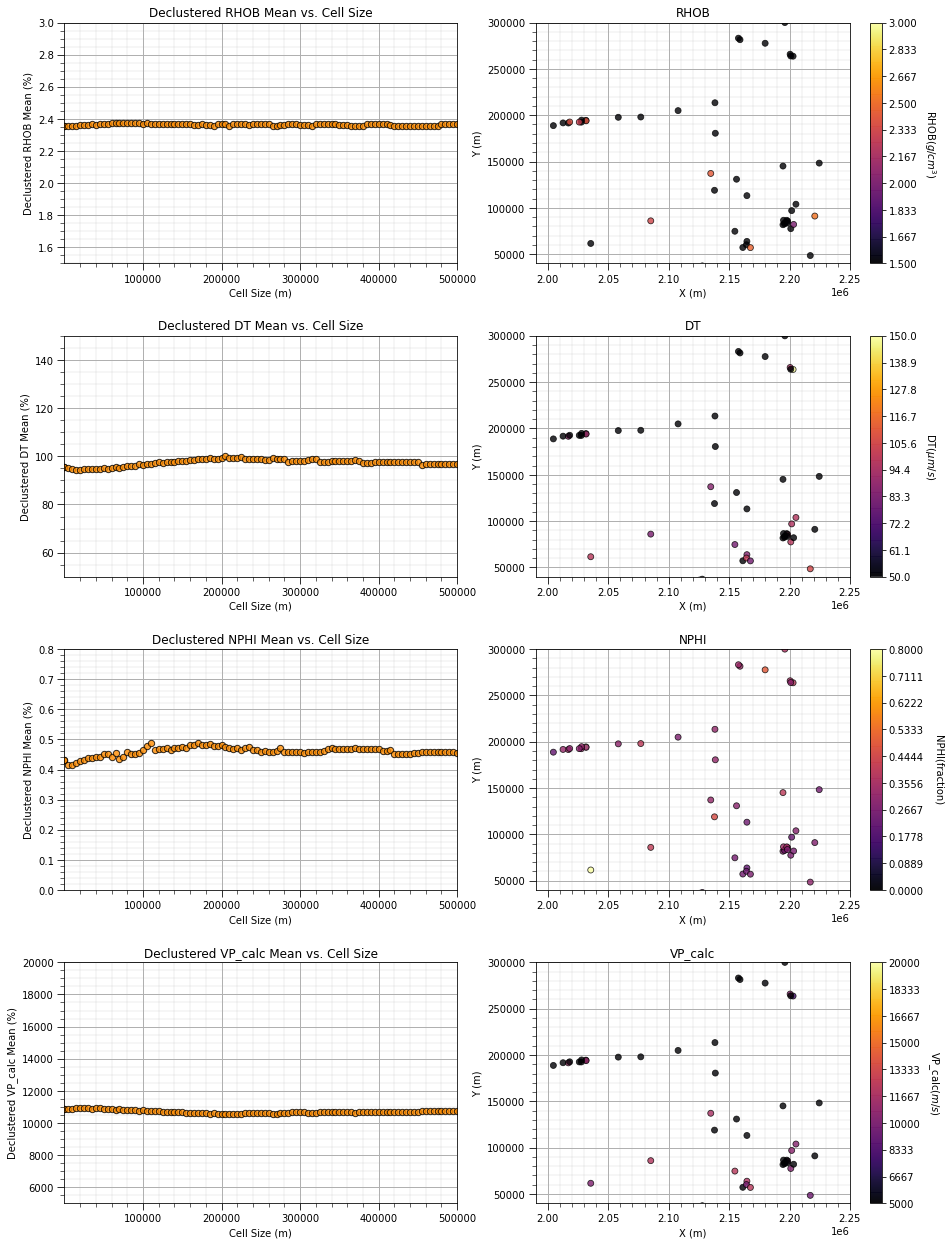

In [26]:
i = 0; tmin = -99999; tmax = 99999
cmin = 100.0; cmax = 500000; ncell = 100; iminmax = 0
iminmax = [1,0,1,1]

cell_size = []; pmean = []; pdmean = []; pvar = []; pdvar = []

for i, feature in enumerate(pfeatures):

    wts, cell_sizes, dmeans = geostats.declus(df_areal[df_areal[pfeatures[i]].between(tmin,tmax)],'X','Y',pfeatures[i],iminmax = iminmax[i], noff= 10, ncell=ncell,cmin=cmin,cmax=cmax)
    if feature == 'NPHI':
        df_areal['Wts'] = wts                            # add weights to the sample data DataFrame
        df_areal.head()                                  # preview to check the sample data DataFrame

    if iminmax == 1:
        icell_size = np.argmin(dmeans)
    else:
        icell_size = np.argmax(dmeans)
    cell_size.append(cell_sizes[icell_size])

    print('Selected Cell Size: ' + str(cell_size[i]))
    
    pmean.append(np.average(df_areal[df_areal[pfeatures[i]].between(tmin,tmax)][pfeatures[i]].mean()))
    pvar.append(df_areal[df_areal[pfeatures[i]].between(tmin,tmax)][pfeatures[i]].var())
    dmean,dstd = weighted_avg_and_std(df_areal[df_areal[pfeatures[i]].between(tmin,tmax)][pfeatures[i]],wts)
    
    pdmean.append(dmean); pdvar.append(dstd*dstd)
    


    print('Naive mean = ' + str(pmean[i]) + ', Declustered mean = ' + str(pdmean[i]) + '.')
  
    plt.subplot(4,2,i*2+1)
    plt.scatter(cell_sizes,dmeans, s=40, alpha = 0.8, edgecolors = "black", facecolors = 'darkorange')
    plt.xlabel('Cell Size (m)')
    plt.ylabel('Declustered ' + pfeatures[i] + ' Mean (%)')
    plt.title('Declustered ' + pfeatures[i] + ' Mean vs. Cell Size')
#     plt.plot([0,cmax],[pmean[i],pmean[i]],color = 'black')
#     plt.plot([cell_size,cell_size],[0,999],color = 'black',linestyle='dashed')
#     plt.plot([0,cmax],[pdmean[i],pdmean[i]],color = 'black',linestyle='dashed')
#     plt.text(cmax*0.5,pmean[i]*0.96, r'Naive ' + pfeatures[i] + ' Mean = ' + str(np.round(pmean[i],2)))
#     plt.text(cmax*0.5,pdmean[i]*1.02, r'Declustered ' + pfeatures[i] + ' Mean = ' + str(np.round(pdmean[i],2)))
#     # plt.text(230., 0.154, r'Minimizing')
#     plt.text(cell_size[i]*.90, pmean[i]*0.8, r'Cell Size = ' + str(np.round(cell_size[i],2)),rotation=90)
    plt.ylim(pmin[i],pmax[i]); plt.xlim(cmin,cmax); add_grid()
    #plt.xscale('log');
    
    plt.subplot(4,2,i*2+2)
    GSLIB.locmap_st(df_areal,"X","Y",pfeatures[i],xmin,xmax,ymin,ymax,pmin[i],pmax[i],pfeatures[i],'X (m)','Y (m)',pfeatures[i] + '(' + punits[i] + ')',cmap)
    add_grid()
    
#     plt.subplot(223)
#     plt.hist(df_areal['Wts'],bins=np.linspace(0.0,2.0,20),color='darkorange',edgecolor='black',alpha=0.8)
#     plt.xlim([0.0,2.0]); plt.xlabel('Weights'); plt.ylabel('Frequency'); plt.title('Declustering Weights')
    
#     plt.subplot(224)
#     GSLIB.locmap_st(df_areal,"X","Y","Wts",xmin,xmax,ymin,ymax,0.0,2.0,'Declustering Weigths','X (m)','Y (m)',"Weights",cmap)
#     add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.1, wspace=0.2, hspace=0.3)
plt.show()

#### Naive and Debiased Distributions

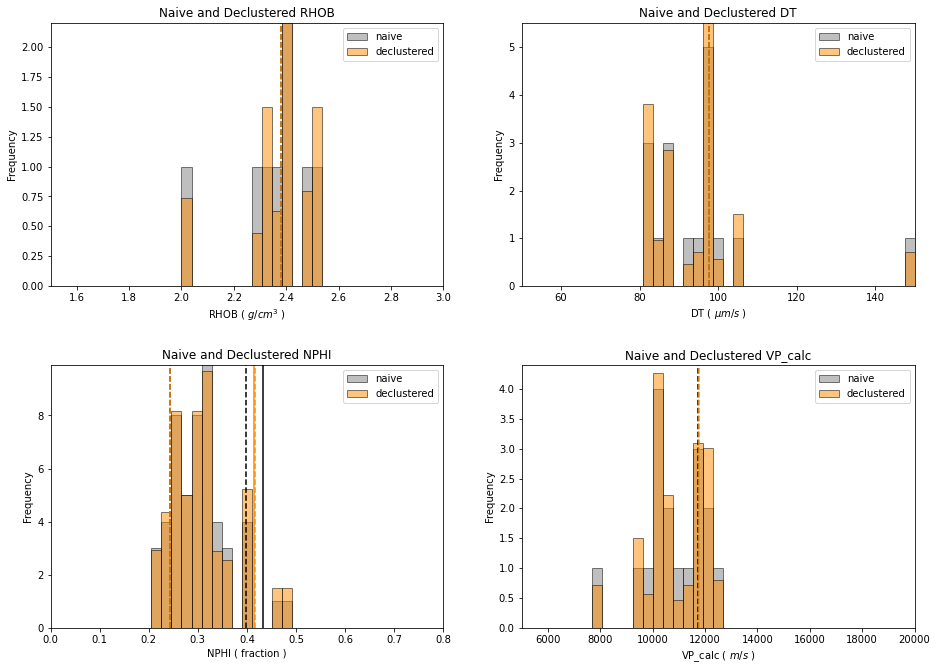

In [27]:
nbins = 40

for i, feature in enumerate(pfeatures):
    plt.subplot(2,2,i+1)
    hist = plt.hist(x=df_areal[feature],weights=None,bins=np.linspace(pmin[i],pmax[i],nbins),alpha = 0.5,edgecolor='black',color='grey',label='naive')
    hist = plt.hist(x=df_areal[feature],weights=df_areal['Wts'],bins=np.linspace(pmin[i],pmax[i],nbins),alpha = 0.5,edgecolor='black',color='darkorange',label='declustered')
    plt.xlabel(pfeatures[i] + ' ( '+ punits[i] + ' )'); 
    plt.ylabel('Frequency'); 
    plt.title('Naive and Declustered ' + pfeatures[i]) # axes labels
    plt.xlim(pmin[i],pmax[i]); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           
    plt.legend(loc='upper right')
    histogram_bounds(df_areal[feature].values,np.ones(len(df_areal)),'black')
    histogram_bounds(df_areal[feature].values,df_areal['Wts'].values,'darkorange')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.3)
plt.show()

#### Spatial Continuity Analysis

0 RHOB
1 DT
2 NPHI
3 VP_calc


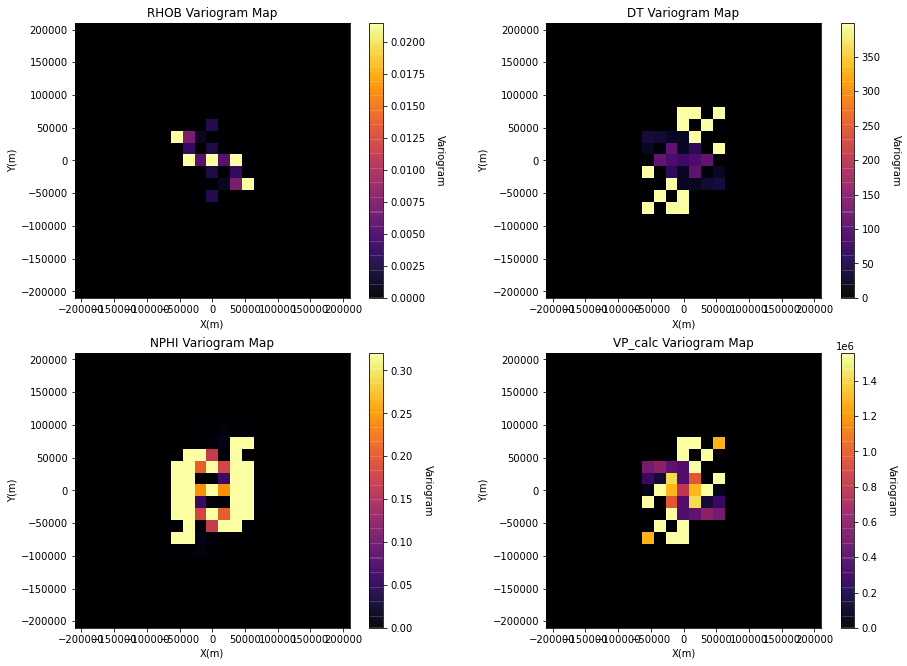

In [30]:
dlag = 50000; nlag = 11
vmap_max = (nlag-1)*dlag+dlag*0.5; vmap_min = -1*vmap_max

vmaps = []; npmaps = []

for i, feature in enumerate(pfeatures):
    print(i,pfeatures[i])
    vmap, npmap = geostats.varmapv(df_areal[df_areal[pfeatures[i]].between(tmin,tmax)],'X','Y',pfeatures[i],tmin=-1.0e21,tmax=1.0e21,nxlag=nlag,nylag=nlag,dxlag=dlag,dylag=dlag,minnp=1,isill=1)
    vmaps.append(vmap); npmaps.append(npmaps)

    plt.subplot(2,2,i+1)
    GSLIB.pixelplt_st(vmaps[i],-210000,210000,-210000,210000,dlag,0,pdvar[i],pfeatures[i] + ' Variogram Map','X(m)','Y(m)','Variogram',cmap)
    plt.gca().add_patch(Ellipse((0,0),width=500000,height=200000,angle=45,facecolor='none',edgecolor='black',label='Low')) 


por_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=240000,hmin1=70000) # porosity variogram
thick_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=240000,hmin1=70000) # thickness variogram

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.2)
plt.show()

#### Areal Trend Model

We have made a kernel of size, number of grid cells (ny, nx) (141, 141)


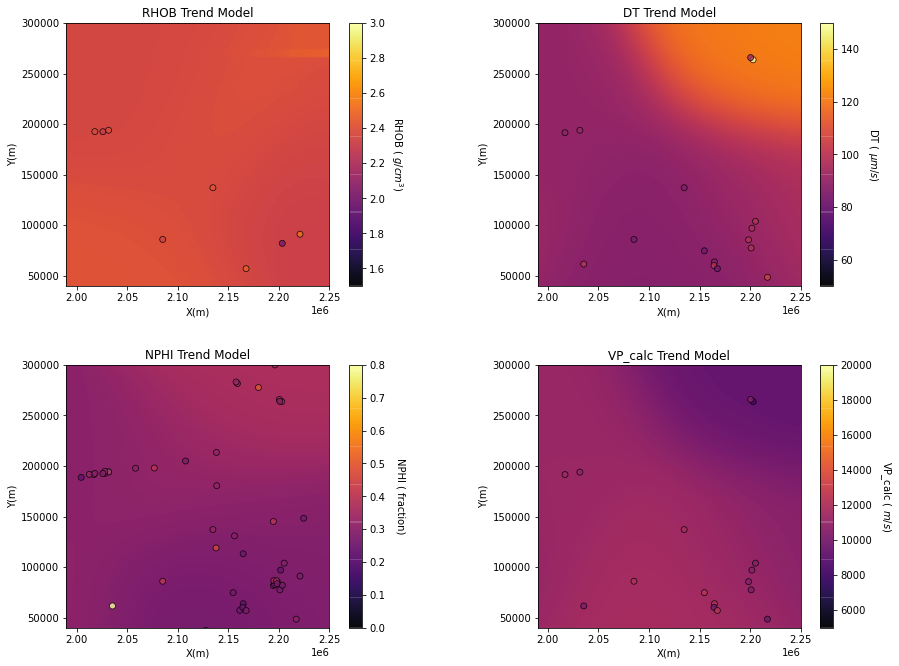

In [31]:
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
                                           # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 40                      # minimum and maximum data for an estimate
tmin = -99999; tmax = 99999              # minimum property value - no trimming limits

trend_range = min((xmax-xmin),(ymax-ymin))
trend_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=trend_range,hmin1=trend_range) # porosity variogram

calculate = True; kriging = False;

trends = np.zeros([ny,nx,len(pfeatures)])

if calculate == True:
    if kriging:
        for i, feature in enumerate(pfeatures):
            trends[:,:,i], _ = geostats.kb2d(df_areal,'X','Y',pfeatures[i],pmin[i],pmax[i],nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
             ndmin,ndmax,trend_range,ktype,pdmean[i],trend_vario)
    else:
        r = 21                             # make the 2D Gaussian kernel
        s = 141
        gkern1d = signal.gaussian(s,r).reshape(s, 1)
        gkern2d = np.outer(gkern1d, gkern1d)
        print('We have made a kernel of size, number of grid cells (ny, nx) ' + str(gkern2d.shape)) 
        for i, feature in enumerate(pfeatures): 
            grid = GSLIB.DataFrame2ndarray(df_areal[df_areal[pfeatures[i]].between(pmin[i],pmax[i])],'X','Y',pfeatures[i],xmin, xmax, ymin, ymax, xsiz) # assumes x and y size are the same
            trends[:,:,i] = convolve(grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)
        
    for i, feature in enumerate(pfeatures):
        np.savetxt(pfeatures[i] + '_trend.csv', trends[:,:,i], delimiter=",") 
    
else:
    for i, feature in enumerate(pfeatures):
        trends[:,:,i] = np.loadtxt(pfeatures[i] + '_trend.csv', delimiter=",")
    
for i, feature in enumerate(pfeatures):
    plt.subplot(2,2,i+1)
    GSLIB.locpix_st(trends[:,:,i],xmin,xmax,ymin,ymax,xsiz,pmin[i],pmax[i],df_areal[df_areal[pfeatures[i]].between(tmin,tmax)],'X','Y',pfeatures[i],pfeatures[i] + ' Trend Model','X(m)','Y(m)',pfeatures[i] + ' ( ' + punits[i] + ')',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.3)
plt.show()

#### Trend Model Analysis

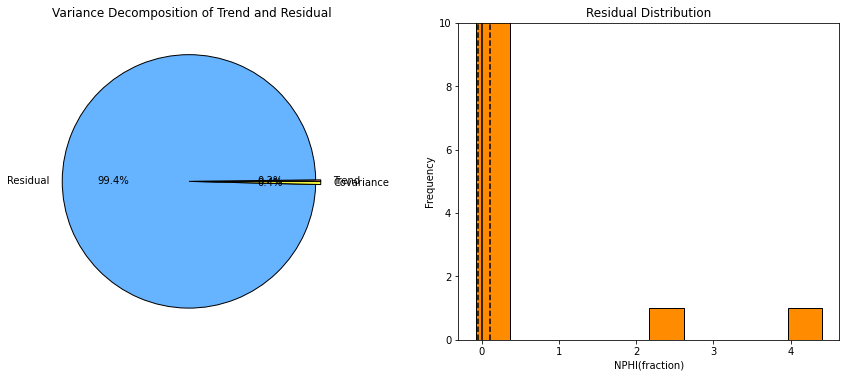

In [33]:
i=2
df_areal = GSLIB.sample(trends[:,:,i],xmin,ymin,xsiz,pfeatures[i] + "_Trend",df_areal,'X','Y')
df_areal[pfeatures[i] + '_Res'] = df_areal[pfeatures[i]] - df_areal[pfeatures[i] + '_Trend'] # calculate the residual and add to DataFrame
df_areal.head()

var_trend = np.var(df_areal[pfeatures[i] + '_Trend']); var_resid = np.var(df_areal[pfeatures[i] + '_Res'])
cov_tr = np.cov(df_areal[pfeatures[i]+'_Trend'],df_areal[pfeatures[i]+'_Res'])[0,0]
var_total = var_trend + var_resid + 2* cov_tr

ptrend = var_trend / var_total; presid = var_resid / var_total; pcov = 2*cov_tr / var_total

plt.subplot(132)
plt.hist(df_areal[pfeatures[i] + '_Res'],color='darkorange',edgecolor='black')
#histogram_bounds(df_centroids['Press'].values,np.ones(len(df_centroids)),'black')
p10,p50,p90 = weighted_percentile(df_areal[pfeatures[i]+ '_Res'].values,np.ones(len(df_areal)),[0.1,0.5,0.9]) 
plt.plot([p10,p10],[0.0,10],color = 'black',linestyle='dashed')
plt.plot([p50,p50],[0.0,10],color = 'black')
plt.plot([p90,p90],[0.0,10],color = 'black',linestyle='dashed')
plt.title('Residual Distribution'); plt.xlabel(pfeatures[i] + '(' + punits[i] + ')'); plt.ylabel('Frequency')
plt.ylim([0,10])

# plt.subplot(133)
# cond_prob_plot(df_areal[pfeatures[i] + '_Trend'],pmin[i],pmax[i],pfeatures[i] + ' Trend','%',3,df_areal[pfeatures[i] + '_Res'],
#                min(df_areal[pfeatures[i] + '_Res'].values),max(df_areal[pfeatures[i] + '_Res'].values),pfeatures[i] + ' Trend Residual',punits[i])

plt.subplot(131)                                       
plt.pie([ptrend, presid, pcov],labels = ['Trend','Residual', 'Covariance'],radius = 1, autopct='%1.1f%%', colors = ['#ff9999','#66b3ff','#edf23a'], explode = [.02,.02,0.02], wedgeprops = {"edgecolor":"k",'linewidth': 1}  )
plt.title('Variance Decomposition of Trend and Residual')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.3)
plt.show()

#### New Trend Features

In [159]:
df_areal.head()

,TVD,RHOB,DT,NPHI,VP_calc,SandPerc,X,Y,Depth,Depth Prime,Top,Base,Thickness,Wts,RHOB_Trend,RHOB_Res,NPHI_Trend,NPHI_Res
UWI,,,,,,,,,,,,,,,,,,
42013321960000,3580.000000,-1.000000e+21,-1.000000e+21,0.367434,-1.000000e+21,2.335492e-01,2.196137e+06,299921.481310,5097.37500,5097.37500,3580.0,6614.75,3034.75,1.501876,2.422795,-1.000000e+21,0.366684,0.000750
42131349470000,8406.452754,-1.000000e+21,-1.000000e+21,0.248840,-1.000000e+21,4.643766e+00,2.161361e+06,57246.543112,12483.41191,12483.41191,8409.0,16557.00,8148.00,1.109687,2.463007,-1.000000e+21,0.271344,-0.022504
42131361850000,8396.000000,-1.000000e+21,8.574767e+01,0.217515,1.188066e+04,1.740691e-01,2.164742e+06,63831.166997,13250.25000,13250.25000,11001.0,15499.50,4498.50,0.967138,2.460904,-1.000000e+21,0.272776,-0.055261
42131361960000,8558.000000,-1.000000e+21,1.003086e+02,0.243466,9.969235e+03,1.686363e+01,2.164315e+06,60216.368039,13985.00000,13985.00000,11000.0,16970.00,5970.00,0.574950,2.462186,-1.000000e+21,0.272194,-0.028728
42131362040000,9062.000000,-1.000000e+21,-1.000000e+21,0.310271,-1.000000e+21,-1.000000e+21,2.154103e+06,31919.636584,9953.00000,9953.00000,9062.0,10844.00,1782.00,1.501876,2.463231,-1.000000e+21,0.269566,0.040705


#### 3D Data Imputation / Prediction - 2D + 1D Method

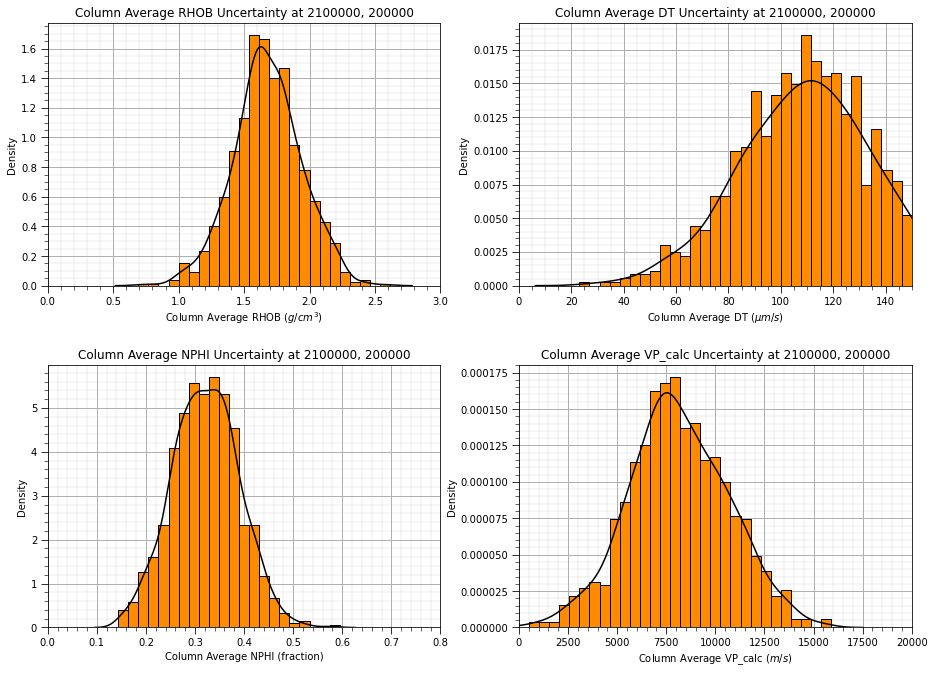

In [160]:
L = 1000

xloc = 2100000; yloc = 200000; depthloc = 4000
ix = geostats.getindex(nx,xmn,xsiz,xloc); iy = ny-geostats.getindex(ny,ymn,ysiz,yloc)-1

locP50 = []; locP10 = []; locP90 = []; locStDev = []

for i, feature in enumerate(pfeatures):
    areal = trends[iy,ix,i]
    P50vertical = P50splines[i](depthloc); locP50.append(areal * P50vertical / pdmean[i])
    P10vertical = P10splines[i](depthloc); locP10.append(areal * P10vertical / pdmean[i])
    P90vertical = P90splines[i](depthloc); locP90.append(areal * P90vertical / pdmean[i])
    locStDev.append((locP90[i] - locP10[i])/2.56310)
    
    realizations = np.random.normal(loc = locP50[i],scale = locStDev[i],size = L)
    
    plt.subplot(2,2,i+1)
    plt.hist(realizations,bins=np.linspace(0,pmax[i],nbins),color='darkorange',edgecolor='black',density = True)
    plt.xlim([0,pmax[i]]); 
    plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
    plt.xlabel('Column Average ' + pfeatures[i] + ' (' + punits[i] + ')'); plt.ylabel('Density'); plt.title('Column Average ' + pfeatures[i] + ' Uncertainty at ' + str(xloc) + ', ' + str(yloc))
    sns.kdeplot(x=realizations,color = 'black',alpha = 1.0,levels = 10)
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.3); plt.show()    